# Analyse des Composantes Principales pour la gestion de portefeuilles d'actions

## Importation des packages

In [56]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import data
import seaborn as sns
import sklearn as sk
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)
np.random.seed(167)

## Vérification des versions

In [57]:
print('Python            version {}'.format(sys.version))
print('Numpy             version {}'.format(np.__version__))
print('Pandas            version {}'.format(pd.__version__))
print('Seabron           version {}'.format(sns.__version__))
print('Sklearn           version {}'.format(sk.__version__))
print('Pandas DataReader version {}'.format(pdr.__version__))

Python            version 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Numpy             version 1.20.3
Pandas            version 1.3.2
Seabron           version 0.11.2
Sklearn           version 1.0.1
Pandas DataReader version 0.10.0


## Récupération des données 

On se focalise sur les N entreprises avec la plus grande capitalisation boursière

In [58]:
# Chargement du fichier comportement les capitalisations boursières
market_cap = pd.read_csv("data/market_cap.csv", index_col=0)
market_cap

,marketCap
A,48856465408
AA,9126754304
AAC,1227499904
AACG,67463472
AACI,202746000
...,...
ZWRK,280600000
ZY,970184512
ZYME,873998144
ZYNE,169543664


In [59]:
# Selection des N plus grandes capitalisations boursières
top_market_cap = market_cap.marketCap.nlargest(29).index
top_market_cap

Index(['MSFT', 'AAPL', 'GOOGL', 'GOOG', 'AMZN', 'TSLA', 'FB', 'GE', 'TSM',
       'JPM', 'V', 'BABA', 'UNH', 'JNJ', 'HD', 'BAC', 'WMT', 'PG', 'MA',
       'ASML', 'ADBE', 'NFLX', 'DIS', 'CRM', 'XOM', 'PFE', 'NKE', 'ORCL',
       'NVO'],
      dtype='object')

In [60]:
# top100_market_cap = ['AAPL','AMZN','BA','BAC','CSCO','CVX','GOOGL','HD','INTC','JNJ','JPM','KO','MA','MSFT','PFE','PG','T','UNH','V','VZ','WFC','WMT','XOM']
# top100_market_cap

In [61]:
# On considère les données à partir de 2010 jusqu'à 2019
start_date = '2010-01-05'
end_date = '2018-12-31'

# On charge les cours d'actions à partir de Yahoo Finance grace au module Pandas_DataReader
stocks = data.DataReader(top_market_cap, 'yahoo', start_date, end_date)[["Adj Close"]].pct_change()
stocks.columns = [k[1] for k in stocks.columns.values]
stocks

,MSFT,AAPL,GOOGL,GOOG,AMZN,TSLA,FB,GE,TSM,JPM,V,BABA,UNH,JNJ,HD,BAC,WMT,PG,MA,ASML,ADBE,NFLX,DIS,CRM,XOM,PFE,NKE,ORCL,NVO
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,-0.006137,-0.015907,-0.025209,-0.025209,-0.018116,NaN,NaN,-0.005151,-0.003470,0.005494,-0.013428,NaN,0.009848,0.008134,-0.003463,0.011728,-0.002235,-0.004743,-0.001446,0.009161,-0.002122,0.035139,-0.005314,-0.001745,0.008643,-0.003215,-0.006097,-0.014504,0.011750
2010-01-07,-0.010400,-0.001849,-0.023280,-0.023280,-0.017013,NaN,NaN,0.051780,-0.033072,0.019810,0.009306,NaN,0.038377,-0.007137,0.011814,0.032947,0.000560,-0.005423,-0.006535,-0.027801,-0.019405,-0.017254,0.000314,-0.004437,-0.003142,-0.003764,0.009814,-0.003271,-0.008557
2010-01-08,0.006896,0.006648,0.013331,0.013331,0.027077,NaN,NaN,0.021538,-0.000900,-0.002456,0.002767,NaN,-0.009391,0.003438,-0.004808,-0.008860,-0.005037,-0.001322,0.000354,-0.023928,-0.005422,0.017176,0.001571,0.001486,-0.004012,0.008095,-0.001974,0.012305,0.011868
2010-01-11,-0.012720,-0.008821,-0.001512,-0.001512,-0.024041,NaN,NaN,0.009639,-0.005406,-0.003357,-0.002873,NaN,0.006728,0.000156,-0.028295,0.008939,0.016501,-0.003971,-0.016458,-0.021226,-0.013083,-0.001313,-0.016311,-0.006743,0.011220,0.008030,-0.012325,0.000405,0.031683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,-0.041739,-0.025874,-0.006638,-0.003389,-0.024313,-0.076242,-0.007123,-0.032168,-0.011762,-0.021557,-0.020361,-0.000833,-0.022657,-0.040987,-0.014581,-0.027385,-0.015035,-0.039683,-0.003082,-0.023173,-0.017433,-0.050773,-0.037133,-0.012855,-0.038315,-0.032912,-0.059002,-0.029773,-0.011016
2018-12-26,0.068310,0.070421,0.064164,0.064780,0.094452,0.103930,0.081573,0.067919,0.041655,0.041459,0.069827,0.046326,0.044690,0.031504,0.064121,0.060713,0.053484,0.031250,0.067449,0.054548,0.086713,0.084616,0.054609,0.078381,0.047779,0.040444,0.072099,0.044507,0.024551
2018-12-27,0.006166,-0.006490,0.004819,0.004252,-0.006295,-0.030544,0.002534,-0.016238,0.000544,0.011255,0.013668,0.003261,0.010766,0.005524,0.012123,0.010784,0.013052,0.021423,0.012123,0.009613,0.009823,0.007490,0.006520,0.033323,0.004371,0.015644,0.009040,0.008522,0.011538


In [62]:
# On retire Tesla, Facebook, Alibaba car leur capital n'était pas ouvert en 2010
# On retire GOOG car c'est (quasiment) un doublon de l'action GOOGL
stocks = stocks.drop(columns=["TSLA", "FB", "BABA", "GOOG"])

## Préparation des données

In [63]:
stocks = stocks.dropna(thresh=int(stocks.shape[0] * .95), axis=1)
stocks = stocks.dropna(thresh=int(stocks.shape[1] * .95))
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2262 entries, 2010-01-06 to 2018-12-31
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MSFT    2262 non-null   float64
 1   AAPL    2262 non-null   float64
 2   GOOGL   2262 non-null   float64
 3   AMZN    2262 non-null   float64
 4   GE      2262 non-null   float64
 5   TSM     2262 non-null   float64
 6   JPM     2262 non-null   float64
 7   V       2262 non-null   float64
 8   UNH     2262 non-null   float64
 9   JNJ     2262 non-null   float64
 10  HD      2262 non-null   float64
 11  BAC     2262 non-null   float64
 12  WMT     2262 non-null   float64
 13  PG      2262 non-null   float64
 14  MA      2262 non-null   float64
 15  ASML    2262 non-null   float64
 16  ADBE    2262 non-null   float64
 17  NFLX    2262 non-null   float64
 18  DIS     2262 non-null   float64
 19  CRM     2262 non-null   float64
 20  XOM     2262 non-null   float64
 21  PFE     2262 non-nu

## Analyse des covariances

In [64]:
cov = stocks.cov()

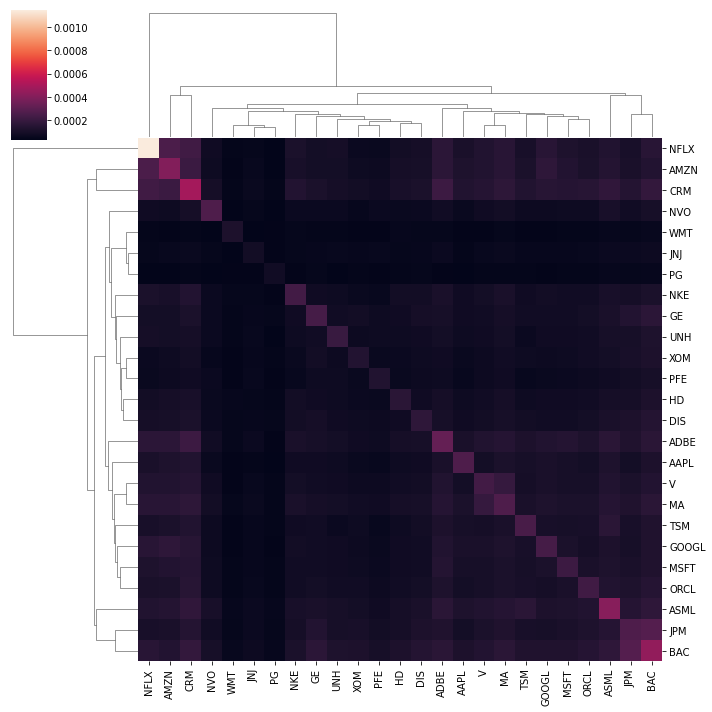

In [65]:
sns.clustermap(cov);

## PCA

In [66]:
pca = PCA()
pca.fit(cov)
pd.Series(pca.explained_variance_ratio_).to_frame('Explained Variance').head(6).style.format('{:,.2%}'.format)

,Explained Variance
0,54.55%
1,19.97%
2,6.57%
3,3.41%
4,2.77%
5,1.84%


In [67]:
pd.Series(pca.explained_variance_ratio_).head(6).sum()

0.8911084268129834

In [68]:
top4 = pd.DataFrame(pca.components_[:6], columns=cov.columns)
eigen_portfolios = top4.div(top4.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range(1, 7)]

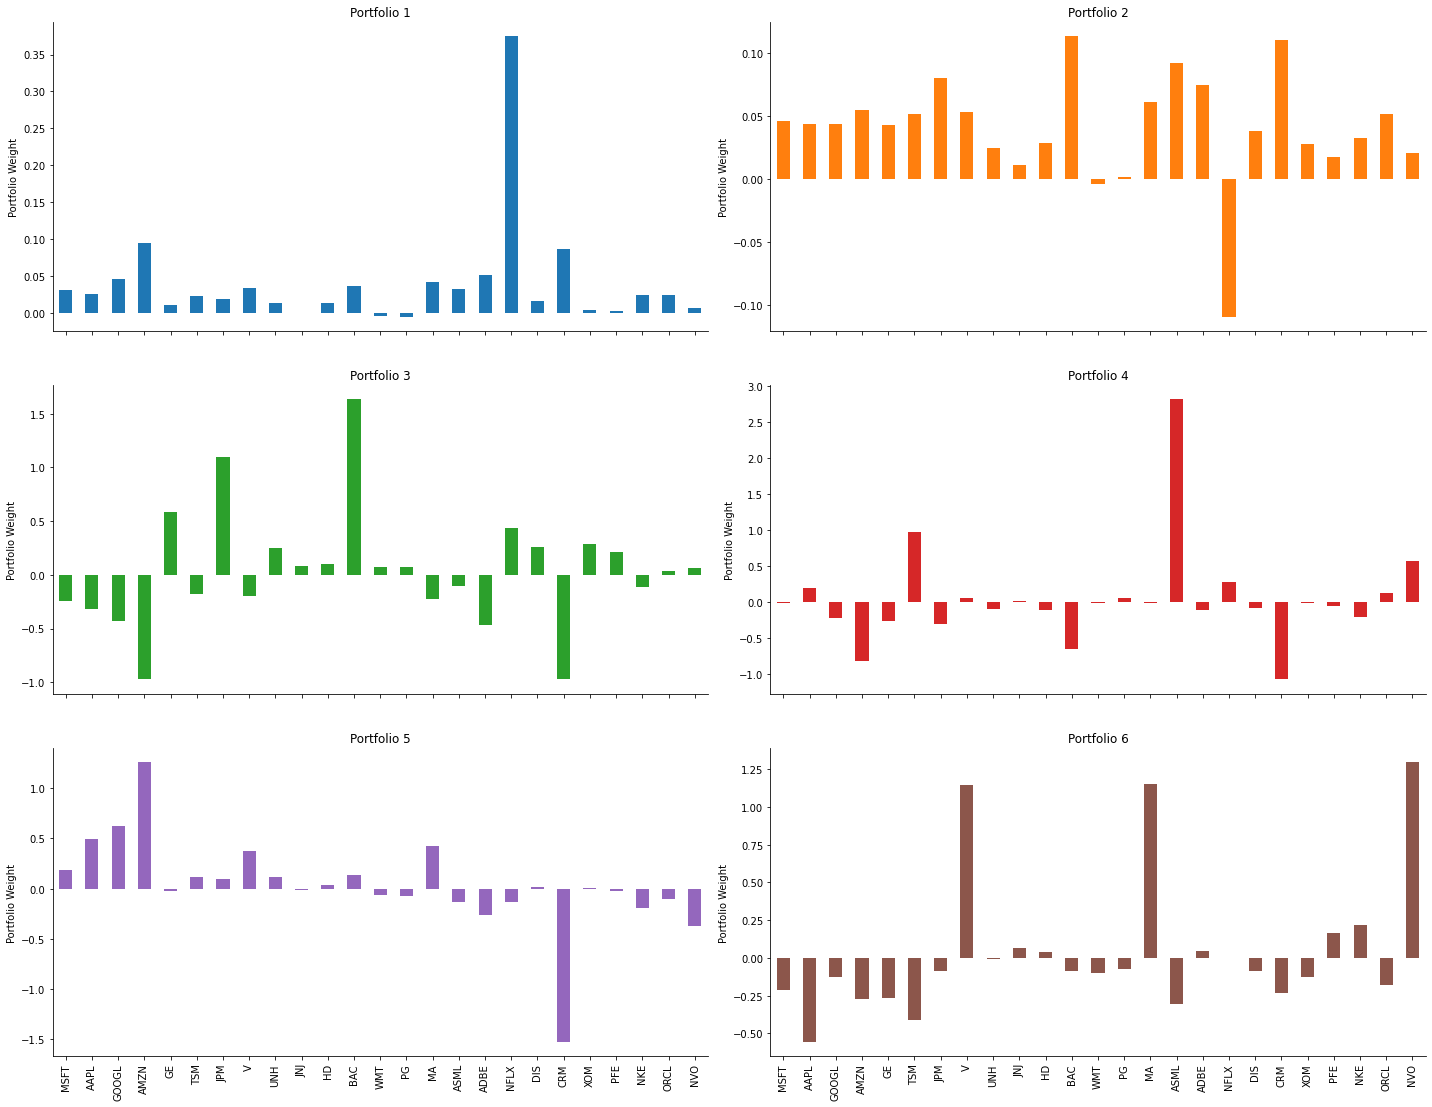

In [69]:
axes = eigen_portfolios.T.plot.bar(subplots=True,
                                   layout=(6, 2),
                                   figsize=(20, 30),
                                   legend=False)
for ax in axes.flatten():
    ax.set_ylabel('Portfolio Weight')
    ax.set_xlabel('')
sns.despine()
plt.tight_layout()

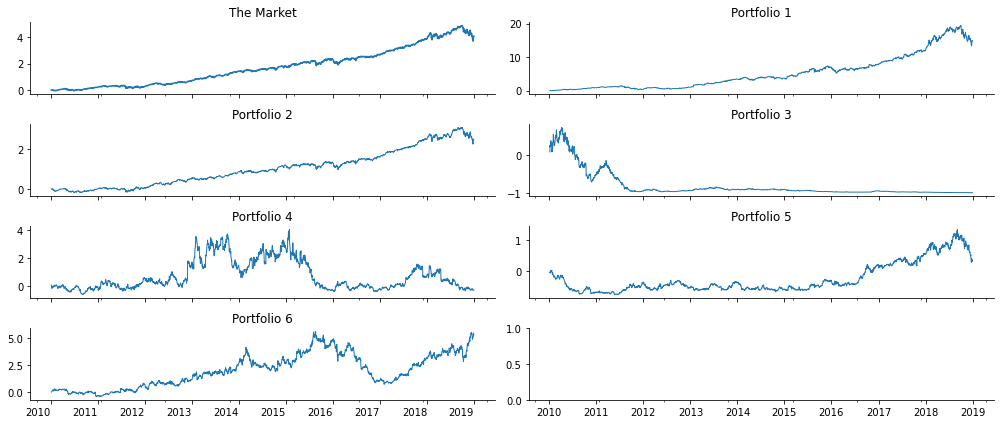

In [70]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 6), sharex=True)
axes = axes.flatten()
stocks.mean(1).add(1).cumprod().sub(1).plot(title='The Market', ax=axes[0])
for i in range(6):
    rc = stocks.mul(eigen_portfolios.iloc[i]).sum(1).add(1).cumprod().sub(1)
    rc.plot(title=f'Portfolio {i+1}', ax=axes[i+1], lw=1, rot=0)

for i in range(7):
    axes[i].set_xlabel('')
sns.despine()
fig.tight_layout()

## Stratégie *long only*

Aussi en considérant une stratégie *long only*, on obtiendrait les résultats suivants

In [81]:
# On retire toutes les valeurs négatives (short) en les remplaceant par zéro
eigen_portfolios[eigen_portfolios < 0] = 0

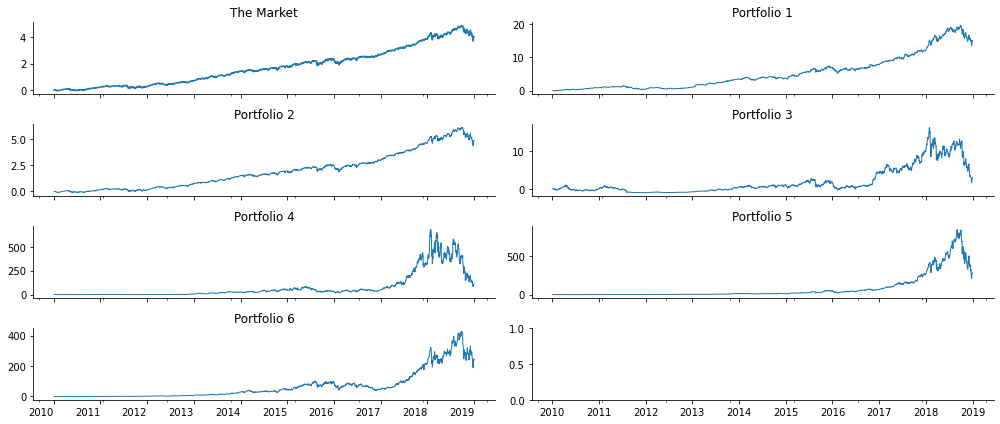

In [79]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 6), sharex=True)
axes = axes.flatten()
stocks.mean(1).add(1).cumprod().sub(1).plot(title='The Market', ax=axes[0])
for i in range(6):
    rc = stocks.mul(eigen_portfolios.iloc[i]).sum(1).add(1).cumprod().sub(1)
    rc.plot(title=f'Portfolio {i+1}', ax=axes[i+1], lw=1, rot=0)

for i in range(7):
    axes[i].set_xlabel('')
sns.despine()
fig.tight_layout()